In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import kagglehub
import os
from torch.utils.data import DataLoader

/home/turtle/anaconda3/envs/project-oval/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CNN_FacialExpression(nn.Module):
    def __init__(self, num_classes=7):
        super(CNN_FacialExpression, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128*6*6, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # Max Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        # Pass through the convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 128*6*6)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [3]:
path = "/1"
model = CNN_FacialExpression(num_classes=7)

In [4]:
# Path to the dataset
dataset_path = os.path.expanduser("~/.cache/kagglehub/datasets/msambare/fer2013/versions/1")

# Image transformations
transform = transforms.Compose([
    transforms.Grayscale(),                # ensure 1 channel
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

# Load training and test datasets
train_dataset = datasets.ImageFolder(os.path.join(dataset_path, "train"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(dataset_path, "test"), transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_FacialExpression(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Save model after each epoch
    model_path = f"./cnn_fer_epoch.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

Epoch [1/30], Loss: 1.6551
Model saved to ./cnn_fer_epoch.pth
Epoch [2/30], Loss: 1.4244
Model saved to ./cnn_fer_epoch.pth
Epoch [3/30], Loss: 1.2854
Model saved to ./cnn_fer_epoch.pth
Epoch [4/30], Loss: 1.1785
Model saved to ./cnn_fer_epoch.pth
Epoch [5/30], Loss: 1.0618
Model saved to ./cnn_fer_epoch.pth
Epoch [6/30], Loss: 0.9532
Model saved to ./cnn_fer_epoch.pth
Epoch [7/30], Loss: 0.8282
Model saved to ./cnn_fer_epoch.pth
Epoch [8/30], Loss: 0.6906
Model saved to ./cnn_fer_epoch.pth
Epoch [9/30], Loss: 0.5367
Model saved to ./cnn_fer_epoch.pth
Epoch [10/30], Loss: 0.3925
Model saved to ./cnn_fer_epoch.pth
Epoch [11/30], Loss: 0.2753
Model saved to ./cnn_fer_epoch.pth
Epoch [12/30], Loss: 0.1798
Model saved to ./cnn_fer_epoch.pth
Epoch [13/30], Loss: 0.1346
Model saved to ./cnn_fer_epoch.pth
Epoch [14/30], Loss: 0.1076
Model saved to ./cnn_fer_epoch.pth
Epoch [15/30], Loss: 0.0980
Model saved to ./cnn_fer_epoch.pth
Epoch [16/30], Loss: 0.0793
Model saved to ./cnn_fer_epoch.pth
E

/tmp/ipykernel_13659/2001924115.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_fer_epoch.pth", map_location=device))


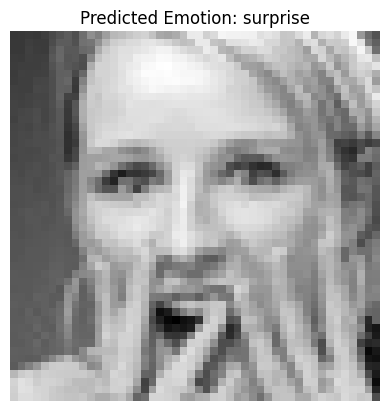

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

model = CNN_FacialExpression(num_classes=7).to(device)
model.load_state_dict(torch.load("cnn_fer_epoch.pth", map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])


image_path = "1/test/surprise/PrivateTest_10775220.jpg" 
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class = torch.max(output.data, 1)

class_labels = train_dataset.classes
predicted_emotion = class_labels[predicted_class.item()]

plt.imshow(image.convert("L"), cmap="gray")
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')
plt.show()

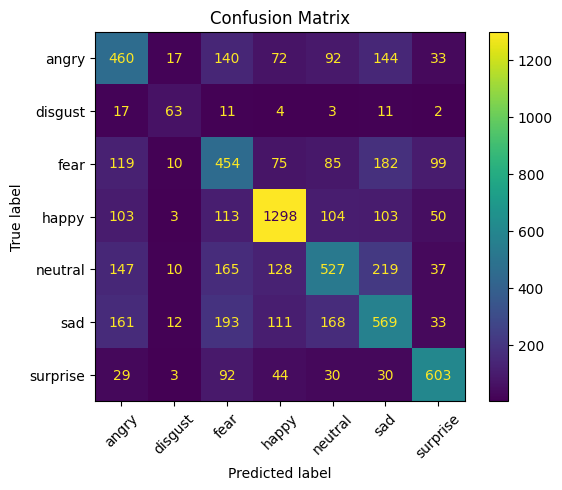

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [8]:
model.load_state_dict(torch.load("cnn_fer_epoch.pth", map_location=device))
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


/tmp/ipykernel_13659/73895399.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_fer_epoch.pth", map_location=device))


Test Accuracy: 55.36%


Evaluating CNN model performance...
Using device: cuda


/tmp/ipykernel_5809/1839151676.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_fer_epoch.pth", map_location=device))


Model loaded successfully
Test Accuracy: 55.36%


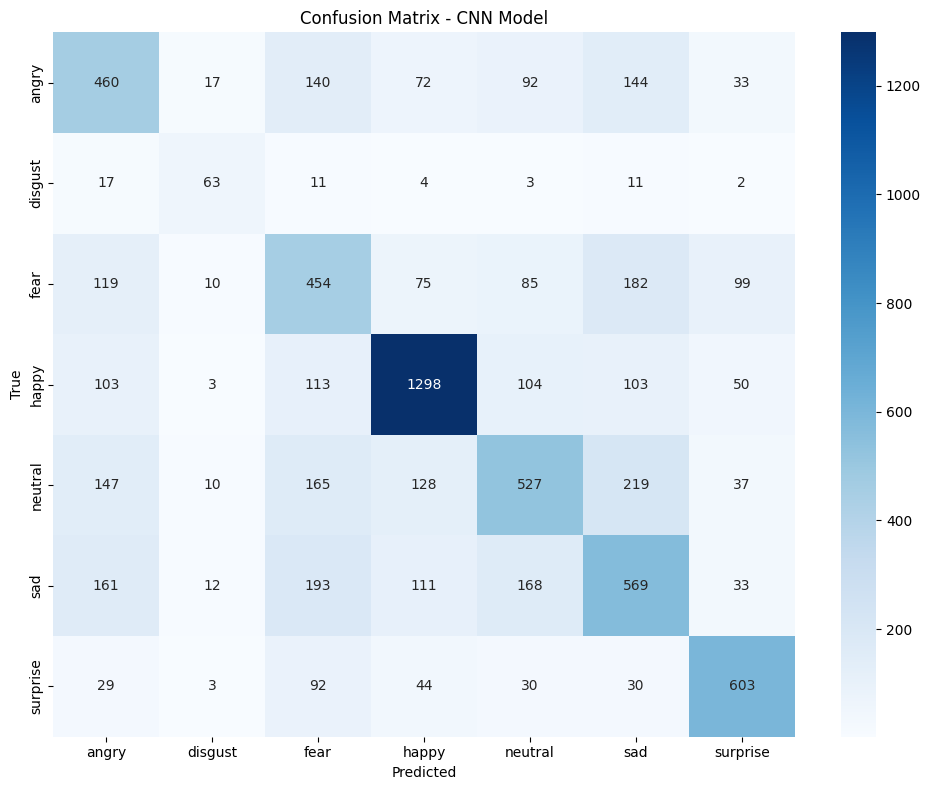

Classification Report:
              precision    recall  f1-score   support

       angry       0.44      0.48      0.46       958
     disgust       0.53      0.57      0.55       111
        fear       0.39      0.44      0.41      1024
       happy       0.75      0.73      0.74      1774
     neutral       0.52      0.43      0.47      1233
         sad       0.45      0.46      0.45      1247
    surprise       0.70      0.73      0.71       831

    accuracy                           0.55      7178
   macro avg       0.54      0.55      0.54      7178
weighted avg       0.56      0.55      0.55      7178



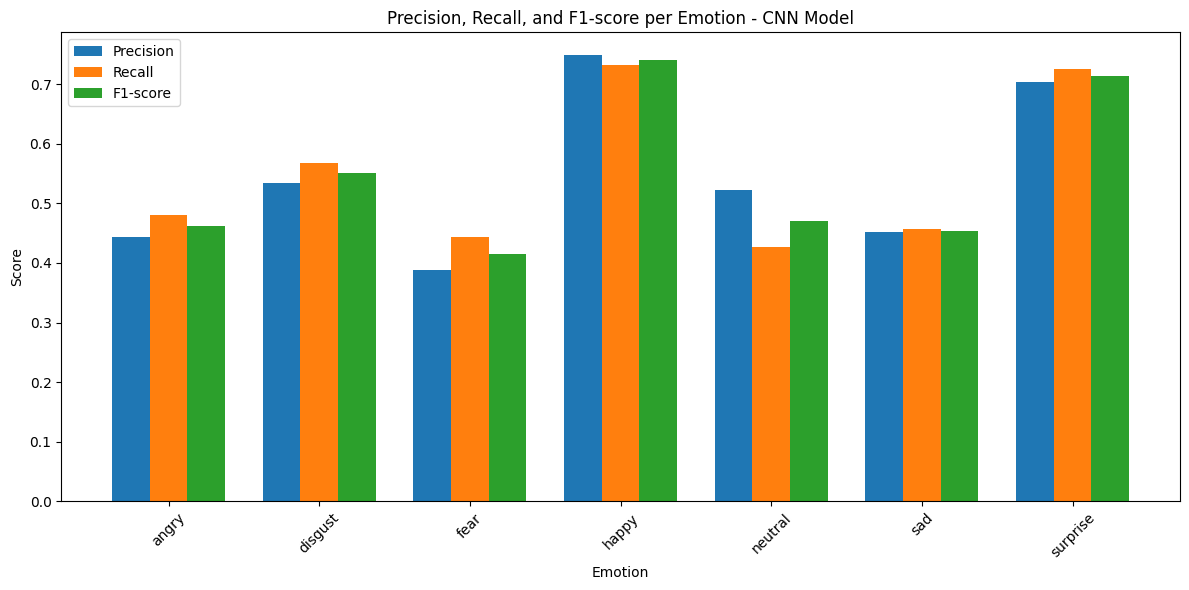

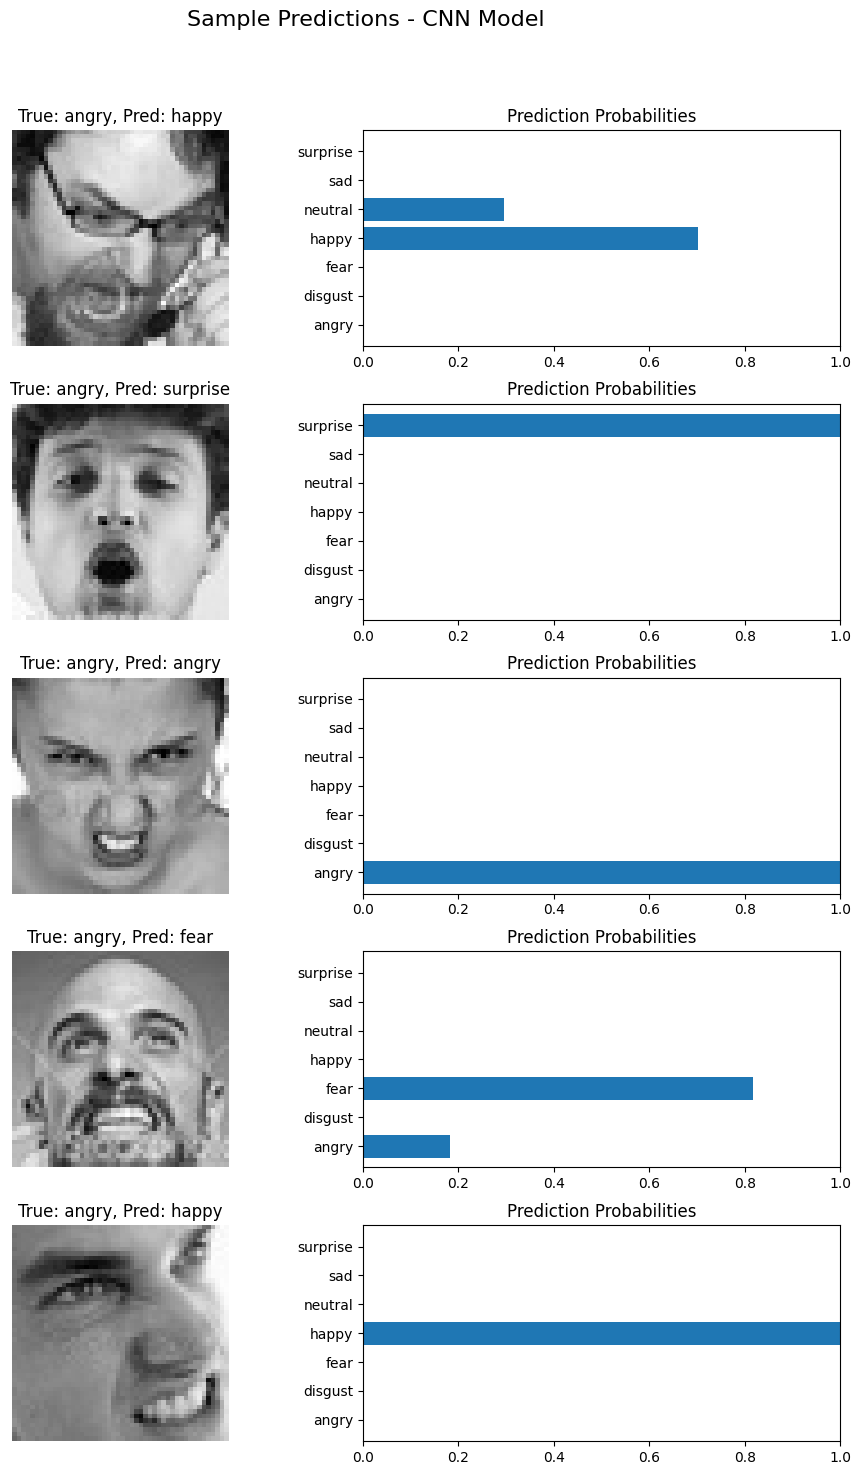

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

def load_and_evaluate_cnn():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    class CNN_FacialExpression(nn.Module):
        def __init__(self, num_classes=7):
            super(CNN_FacialExpression, self).__init__()
            
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

            self.fc1 = nn.Linear(128*6*6, 512)
            self.fc2 = nn.Linear(512, num_classes)

            self.pool = nn.MaxPool2d(2, 2)
        
        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))

            x = x.view(-1, 128*6*6)
            
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            
            return x
    
    import torchvision.transforms as transforms
    from torchvision import datasets
    import os
    import torch.nn.functional as F
    
    # Path to the dataset
    dataset_path = os.path.expanduser("~/.cache/kagglehub/datasets/msambare/fer2013/versions/1")
    
    # Image transformations
    transform = transforms.Compose([
        transforms.Grayscale(),                # ensure 1 channel
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
    ])
    
    test_dataset = datasets.ImageFolder(os.path.join(dataset_path, "test"), transform=transform)
    
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    model = CNN_FacialExpression(num_classes=7).to(device)
    
    try:
        model.load_state_dict(torch.load("cnn_fer_epoch.pth", map_location=device))
        print("Model loaded successfully")
    except Exception as e:
        print(f"Error loading model: {e}")
        return
    
    model.eval()
    
    all_predictions = []
    all_labels = []
    
    # Evaluate the model
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    
    # Get emotion labels (class names)
    emotion_labels = test_dataset.classes
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=emotion_labels, 
                yticklabels=emotion_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - CNN Model')
    plt.tight_layout()
    plt.savefig('cnn_confusion_matrix.png')
    plt.show()
    
    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None)
    
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=emotion_labels))
    
    # Plot per-class metrics
    plt.figure(figsize=(12, 6))
    x = np.arange(len(emotion_labels))
    width = 0.25
    
    plt.bar(x - width, precision, width, label='Precision')
    plt.bar(x, recall, width, label='Recall')
    plt.bar(x + width, f1, width, label='F1-score')
    
    plt.xlabel('Emotion')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-score per Emotion - CNN Model')
    plt.xticks(x, emotion_labels, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig('cnn_per_class_metrics.png')
    plt.show()
    
    def visualize_predictions(num_samples=5):
        fig, axes = plt.subplots(num_samples, 2, figsize=(10, 3*num_samples))
        fig.suptitle('Sample Predictions - CNN Model', fontsize=16)
        
        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                if i >= num_samples:
                    break
                    
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                
                img = images[0].cpu().squeeze().numpy()
                true_label = emotion_labels[labels[0].item()]
                pred_label = emotion_labels[predicted[0].item()]
                
                probs = torch.nn.functional.softmax(outputs[0], dim=0).cpu().numpy()
                
                axes[i, 0].imshow(img, cmap='gray')
                axes[i, 0].set_title(f'True: {true_label}, Pred: {pred_label}')
                axes[i, 0].axis('off')
                
                axes[i, 1].barh(emotion_labels, probs)
                axes[i, 1].set_xlim(0, 1)
                axes[i, 1].set_title('Prediction Probabilities')
                
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.savefig('cnn_sample_predictions.png')
        plt.show()
    
    visualize_predictions()
    
    return accuracy, precision, recall, f1

from torch.utils.data import DataLoader

if __name__ == "__main__":
    print("Evaluating CNN model performance...")
    try:
        accuracy, precision, recall, f1 = load_and_evaluate_cnn()
    except Exception as e:
        print(f"An error occurred: {e}")